In [1]:
# Modules

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

import sys
sys.path.insert(0,'../')  # add previous directory to path to load constants module
import constants as const

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt
print(tf.__version__)

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
import statistics


2024-10-09 09:25:08.005126: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-09 09:25:08.036094: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-09 09:25:08.173371: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-09 09:25:08.173418: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-09 09:25:08.201021: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

2.15.0


In [5]:
# Load existing Pphys model
from keras import backend as K
from keras.layers import Input, Lambda
from keras.layers import Concatenate
Cp_max = 0.5926
V_mean = 6.314169410268349
V_std = 1.9826865496833004

Pphys_model = tf.keras.models.load_model('../Models/Pphys.h5')
Pphys_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 V (InputLayer)              [(None, 1)]                  0         []                            
                                                                                                  
 theta (InputLayer)          [(None, 1)]                  0         []                            
                                                                                                  
 W (InputLayer)              [(None, 1)]                  0         []                            
                                                                                                  
 concatenate (Concatenate)   (None, 3)                    0         ['V[0][0]',                   
                                                                     'theta[0][0]',           

In [27]:
# Load existing Pres model
Pres_norm_model = tf.keras.models.load_model('../Models/Pres.h5')
Pres_norm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 256)               3840      
                                                                 
 dense_3 (Dense)             (None, 256)               65792     
                                                                 
 dense_4 (Dense)             (None, 256)               65792     
                                                                 
 dense_5 (Dense)             (None, 256)               65792     
                                                                 
 dense_6 (Dense)             (None, 1)                 257       
                                                                 
Total params: 201473 (787.00 KB)
Trainable params: 201473 (787.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [32]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Lambda

# Define Pres model to output the residual power in original units
Pres_mean = 590.292648
Pres_std = 30315.169840

input_shape = Pres_norm_model.input_shape[1:]  # Get the input shape of P_old
input_layer = Input(shape=input_shape)

# Normalized output
output_norm = Pres_norm_model(input_layer)
# Scale the output
output_new = Lambda(lambda x: x * Pres_std + Pres_mean)(output_norm)

# Define the new model
Pres_model = Model(inputs=input_layer, outputs=output_new)

# Optional: Compile the new model if you plan to train it further
#Pres_model.compile(optimizer='adam', loss='mean_squared_error')

# Print the model summary to verify
Pres_model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 14)]              0         
                                                                 
 sequential_1 (Sequential)   (None, 1)                 201473    
                                                                 
 lambda_28 (Lambda)          (None, 1)                 0         
                                                                 
Total params: 201473 (787.00 KB)
Trainable params: 201473 (787.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [33]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Add, Lambda
import tensorflow.keras.backend as K

# Add Pphys and Pres to obtain the Phybrid
print(Pphys_model.input_shape)
print(Pres_model.input_shape)

# Pphys has three inputs, each (None, 1), and Pres has an input of shape (None, 14)

# Step 1: Define the global input layer (shape is (None, 14))
global_input = Input(shape=(14,))

# Step 2: Slice the global input for Pphys input 
# (take variables V, theta, and W, at indices 6, 0, and 10)
phys_input_1 = Lambda(lambda x: x[:, 6:7])(global_input)  # Shape (None, 1)
phys_input_2 = Lambda(lambda x: x[:, 0:1])(global_input)  # Shape (None, 1)
phys_input_3 = Lambda(lambda x: x[:, 10:11])(global_input)  # Shape (None, 1)

# Step 3: Evaluate Pphys model
Pphys_output = Pphys_model([phys_input_1, phys_input_2, phys_input_3])

# Step 4: Evaluate Pres model
Pres_output = Pres_model(global_input)  

# Step 5: Add the two outputs to get the final hybrid output
Phybrid_output = Add()([Pphys_output, Pres_output])

# Step 6: Define the final model
Phybrid_model = Model(inputs=global_input, outputs=Phybrid_output)

tf.keras.utils.plot_model(Phybrid_model, to_file='Phybrid_model.png', show_shapes=True, show_layer_names=True)

# Compile the model if needed if you plan to train it further
#Phybrid_model.compile(optimizer='adam', loss='mse')

# Check the model summary
Phybrid_model.summary()


[(None, 1), (None, 1), (None, 1)]
(None, 14)
Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_12 (InputLayer)       [(None, 14)]                 0         []                            
                                                                                                  
 lambda_29 (Lambda)          (None, 1)                    0         ['input_12[0][0]']            
                                                                                                  
 lambda_30 (Lambda)          (None, 1)                    0         ['input_12[0][0]']            
                                                                                                  
 lambda_31 (Lambda)          (None, 1)                    0         ['input_12[0][0]']            
                                               

In [34]:
# Load on test dataset
# Quizás hacer esto para todos los datos, no solo test dataset
test_dataset = pd.read_csv('../Datasets/Dataset_test_paper.csv')
print("Shape of dataset: "+str(test_dataset.shape))
test_dataset.tail()

Shape of dataset: (120530, 15)


,Unnamed: 0,theta,hub_temperature,nacelle_angle,nacelle_temperature,V1,V2,V,Wind_angle,Vane_angle,Out_temperature,W,Rotor_temperature,Wind_angle_c,nacelle_angle_c
120525,602624,2.261595,0.001683,0.504203,-1.446023,6.530189,5.922329,6.246994,0.294367,-1.062332,-0.523592,1.372620,0.153446,0.300286,0.298495
120526,602627,2.731609,0.332242,-0.034572,-0.858250,6.500469,6.361835,6.448740,0.140969,0.734560,0.195539,1.369336,-0.020485,0.146209,-0.027758
120527,602631,2.669721,-0.183293,0.649597,-1.336219,6.550003,6.361835,6.473959,0.690358,0.372848,-0.362845,1.375905,0.055875,0.698028,0.695879
120528,602632,2.867093,-0.010306,0.035759,-1.069784,6.401401,6.596919,6.514308,0.020965,-0.170250,0.060173,1.369336,0.363437,0.025675,0.042941
120529,602633,2.885492,-0.010306,0.035759,-0.917996,6.559909,6.499819,6.549613,-0.035589,-0.723956,0.058763,1.369336,0.480099,-0.031130,0.042941


In [35]:
# Check overal statistis of each input feature 
test_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,120530.0,301534.635443,174263.658860,2.000000,150020.500000,301226.500000,453104.500000,602633.000000
theta,120530.0,-0.002931,0.982693,-0.167090,-0.153709,-0.152036,-0.136982,15.483876
hub_temperature,120530.0,-0.005157,0.999183,-2.414995,-0.854688,-0.083954,0.674790,3.415176
nacelle_angle,120530.0,-0.002617,1.000228,-1.940179,-0.854241,0.217932,0.704200,1.931257
nacelle_temperature,120530.0,-0.004597,1.001883,-3.730909,-0.646717,0.078311,0.703223,2.957428
V1,120530.0,0.002629,1.000885,-3.123925,-0.676961,-0.216298,0.412780,6.559909
V2,120530.0,0.002784,1.000699,-3.230637,-0.680481,-0.215422,0.423394,6.596919
V,120530.0,0.002711,1.000811,-3.068649,-0.677954,-0.213937,0.416521,6.549613
Wind_angle,120530.0,-0.001385,1.000385,-1.939600,-0.847069,0.209428,0.698976,1.938441
Vane_angle,120530.0,0.001283,0.988996,-18.768196,-0.546813,-0.029172,0.531959,18.990949


3767/3767 [==============================] - 2s 545us/step


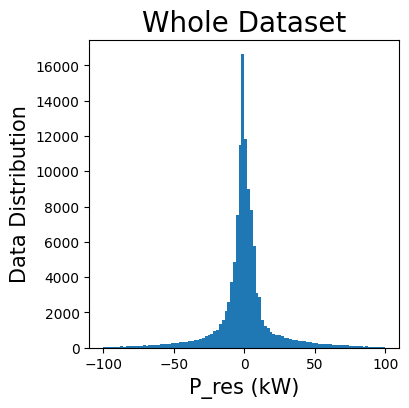

3767/3767 [==============================] - 2s 597us/step


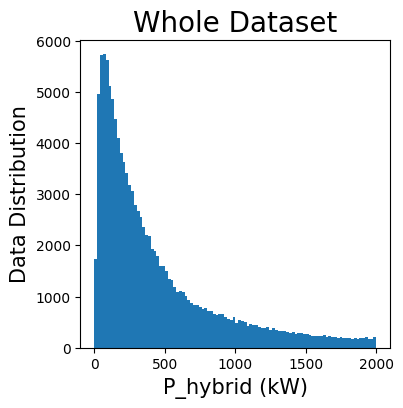

(120530, 3)
3767/3767 [==============================] - 2s 450us/step


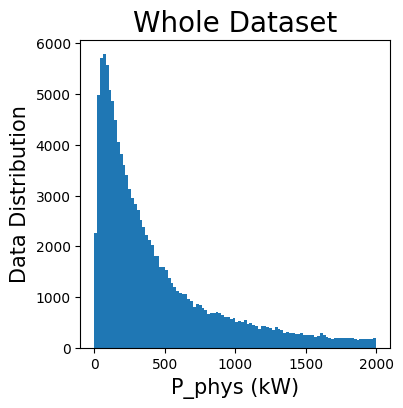

In [53]:
# Plot distributions of P_res in kW
selected_columns = test_dataset.iloc[:,1:15]
x_input = selected_columns.to_numpy()
Pres_data = Pres_model.predict(x_input)
plt.figure(figsize=(4,4))
#plt.hist(Pres_data, range=[2.5, 15], bins=100)
plt.hist(Pres_data/1000, range=[-100, 100], bins=100)
plt.xlabel('P_res (kW)',fontsize=15)
plt.ylabel('Data Distribution',fontsize=15)
plt.title('Whole Dataset',fontsize=20)
plt.show()

# Plot distribution of P_hybrid in kW
Phybrid_data = Phybrid_model.predict(x_input)
plt.figure(figsize=(4,4))
#plt.hist(Pres_data, range=[2.5, 15], bins=100)
plt.hist(Phybrid_data/1000, range=[0, 2000], bins=100)
plt.xlabel('P_hybrid (kW)',fontsize=15)
plt.ylabel('Data Distribution',fontsize=15)
plt.title('Whole Dataset',fontsize=20)
plt.show()

# Plot distribution of P_phys in kW
selected_columns = test_dataset[['V', 'theta', 'W']]
xphys_input = selected_columns.to_numpy()
print(xphys_input.shape)
Pphys_data = Pphys_model.predict([xphys_input[:,0],xphys_input[:,1],xphys_input[:,2]])
plt.figure(figsize=(4,4))
#plt.hist(Pres_data, range=[2.5, 15], bins=100)
plt.hist(Pphys_data/1000, range=[0, 2000], bins=100)
plt.xlabel('P_phys (kW)',fontsize=15)
plt.ylabel('Data Distribution',fontsize=15)
plt.title('Whole Dataset',fontsize=20)
plt.show()

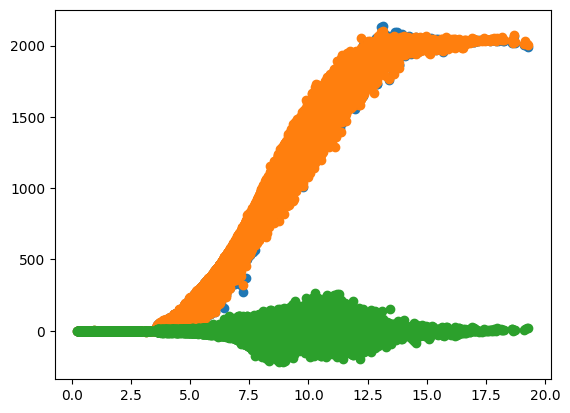

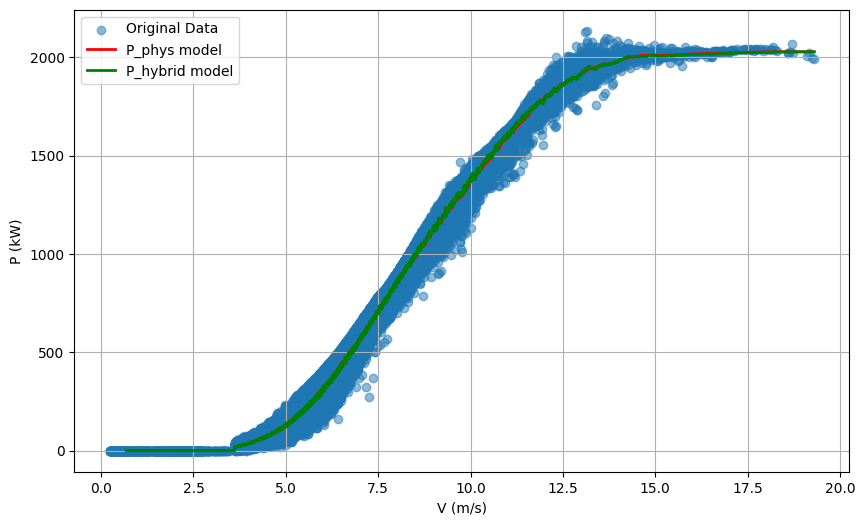

In [97]:
V_original = xphys_input[:,0] * V_std + V_mean
plt.scatter(V_original,Pphys_data/1000)
plt.scatter(V_original,Phybrid_data/1000)
plt.scatter(V_original,Pres_data/1000)
plt.show()

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

x = V_original
y = Pphys_data
yh = Phybrid_data


# Sort the x and corresponding y values
sorted_indices = np.argsort(x)
x_sorted = x[sorted_indices]
y_sorted = y[sorted_indices]
yh_sorted = yh[sorted_indices]

# Ensure y_sorted is a 1D vector (it should be, but we can use ravel() to be sure)
y_sorted = y_sorted.ravel()  # This ensures it's a 1D array
yh_sorted = yh_sorted.ravel()  # This ensures it's a 1D array

# Calculate moving average
window_size = 100
# Use np.convolve with 'valid' mode to handle edges properly
y_smoothed = np.convolve(y_sorted, np.ones(window_size)/window_size, mode='valid')
yh_smoothed = np.convolve(yh_sorted, np.ones(window_size)/window_size, mode='valid')

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(x_sorted, y_sorted/1000, label='Original Data', alpha=0.5)
plt.plot(x_sorted[window_size-1:], y_smoothed/1000, color='red', label='P_phys model', linewidth=2)
plt.plot(x_sorted[window_size-1:], yh_smoothed/1000, color='green', label='P_hybrid model', linewidth=2)
#plt.title('Moving Average Smoothing with Unordered Data')
plt.xlabel('V (m/s)')
plt.ylabel('P (kW)')
plt.legend()
plt.grid()
plt.show()

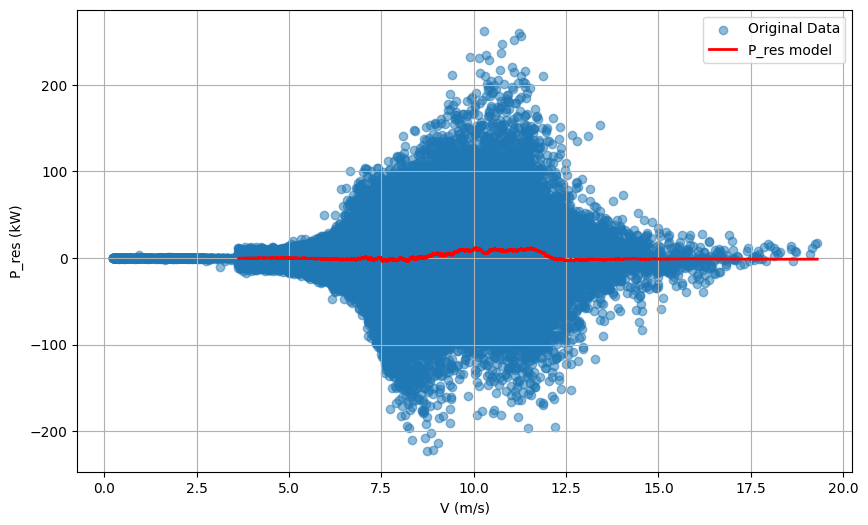

In [94]:
# Plot Pres vs V
x = V_original
y = Pres_data

# Sort the x and corresponding y values
sorted_indices = np.argsort(x)
x_sorted = x[sorted_indices]
y_sorted = y[sorted_indices]

# Ensure y_sorted is a 1D vector (it should be, but we can use ravel() to be sure)
y_sorted = y_sorted.ravel()  # This ensures it's a 1D array

# Calculate moving average
window_size = 1000
# Use np.convolve with 'valid' mode to handle edges properly
y_smoothed = np.convolve(y_sorted, np.ones(window_size)/window_size, mode='valid')

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(x_sorted, y_sorted/1000, label='Original Data', alpha=0.5)
plt.plot(x_sorted[window_size-1:], y_smoothed/1000, color='red', label='P_res model', linewidth=2)
#plt.title('Moving Average Smoothing with Unordered Data')
plt.xlabel('V (m/s)')
plt.ylabel('P_res (kW)')
plt.legend()
plt.grid()
plt.show()